## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
from scipy import stats

In [249]:
df = pd.read_csv('./data/kc_house_data.csv')
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0      5650     1.0        NaN  NONE  ...      7 Average       1180   
1      7242     2.0         NO  NONE  ...      7 Average       2170   
2     10000     1.0         NO  NONE  ...  6 Low Average        770   
3      5000     1.0         NO  NONE  ...      7 Average       1050   
4      8080     1.0         NO  NONE  ...         8 Good       1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [250]:
df = df[(df['grade'] != '13 Mansion') & (df['grade'] != '12 Luxury')]
df = df[df['price'] <= 2000000]
df['view'] = df['view'].fillna('NONE')
df['waterfront'] =df['waterfront'].fillna('NO')
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df = df[stats.zscore(df.bedrooms) < 5]

lotiqr = df.sqft_lot.quantile(0.75) - df.sqft_lot.quantile(0.25)
df = df[df.sqft_lot <= (df.sqft_lot.quantile(0.75) + (10 * lotiqr))]

lot15iqr = df.sqft_lot15.quantile(0.75) - df.sqft_lot15.quantile(0.25)
df = df[df.sqft_lot15 <= (df.sqft_lot15.quantile(0.75) + (10 * lot15iqr))]

liviqr = df.sqft_living.quantile(0.75) - df.sqft_living.quantile(0.25)
df = df[df.sqft_living <= (df.sqft_living.quantile(0.75) + (4 * liviqr))]

abiqr = df.sqft_above.quantile(0.75) - df.sqft_above.quantile(0.25)
df = df[df.sqft_above <= (df.sqft_above.quantile(0.75) + (4 * abiqr))]

df = df.drop('id', axis = 1)
df.sqft_basement = df.sqft_basement.str.replace('?', '0.0', regex = True)
df.sqft_basement = df.sqft_basement.astype('float64')
df['date'] = pd.to_datetime(df.date)
df['yr_renovated'] = df['yr_renovated'].map(lambda x: 0 if x == 0.0 else 1)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20541 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20541 non-null  datetime64[ns]
 1   price          20541 non-null  float64       
 2   bedrooms       20541 non-null  int64         
 3   bathrooms      20541 non-null  float64       
 4   sqft_living    20541 non-null  int64         
 5   sqft_lot       20541 non-null  int64         
 6   floors         20541 non-null  float64       
 7   waterfront     20541 non-null  object        
 8   view           20541 non-null  object        
 9   condition      20541 non-null  object        
 10  grade          20541 non-null  object        
 11  sqft_above     20541 non-null  int64         
 12  sqft_basement  20541 non-null  float64       
 13  yr_built       20541 non-null  int64         
 14  yr_renovated   20541 non-null  int64         
 15  zipcode        2054

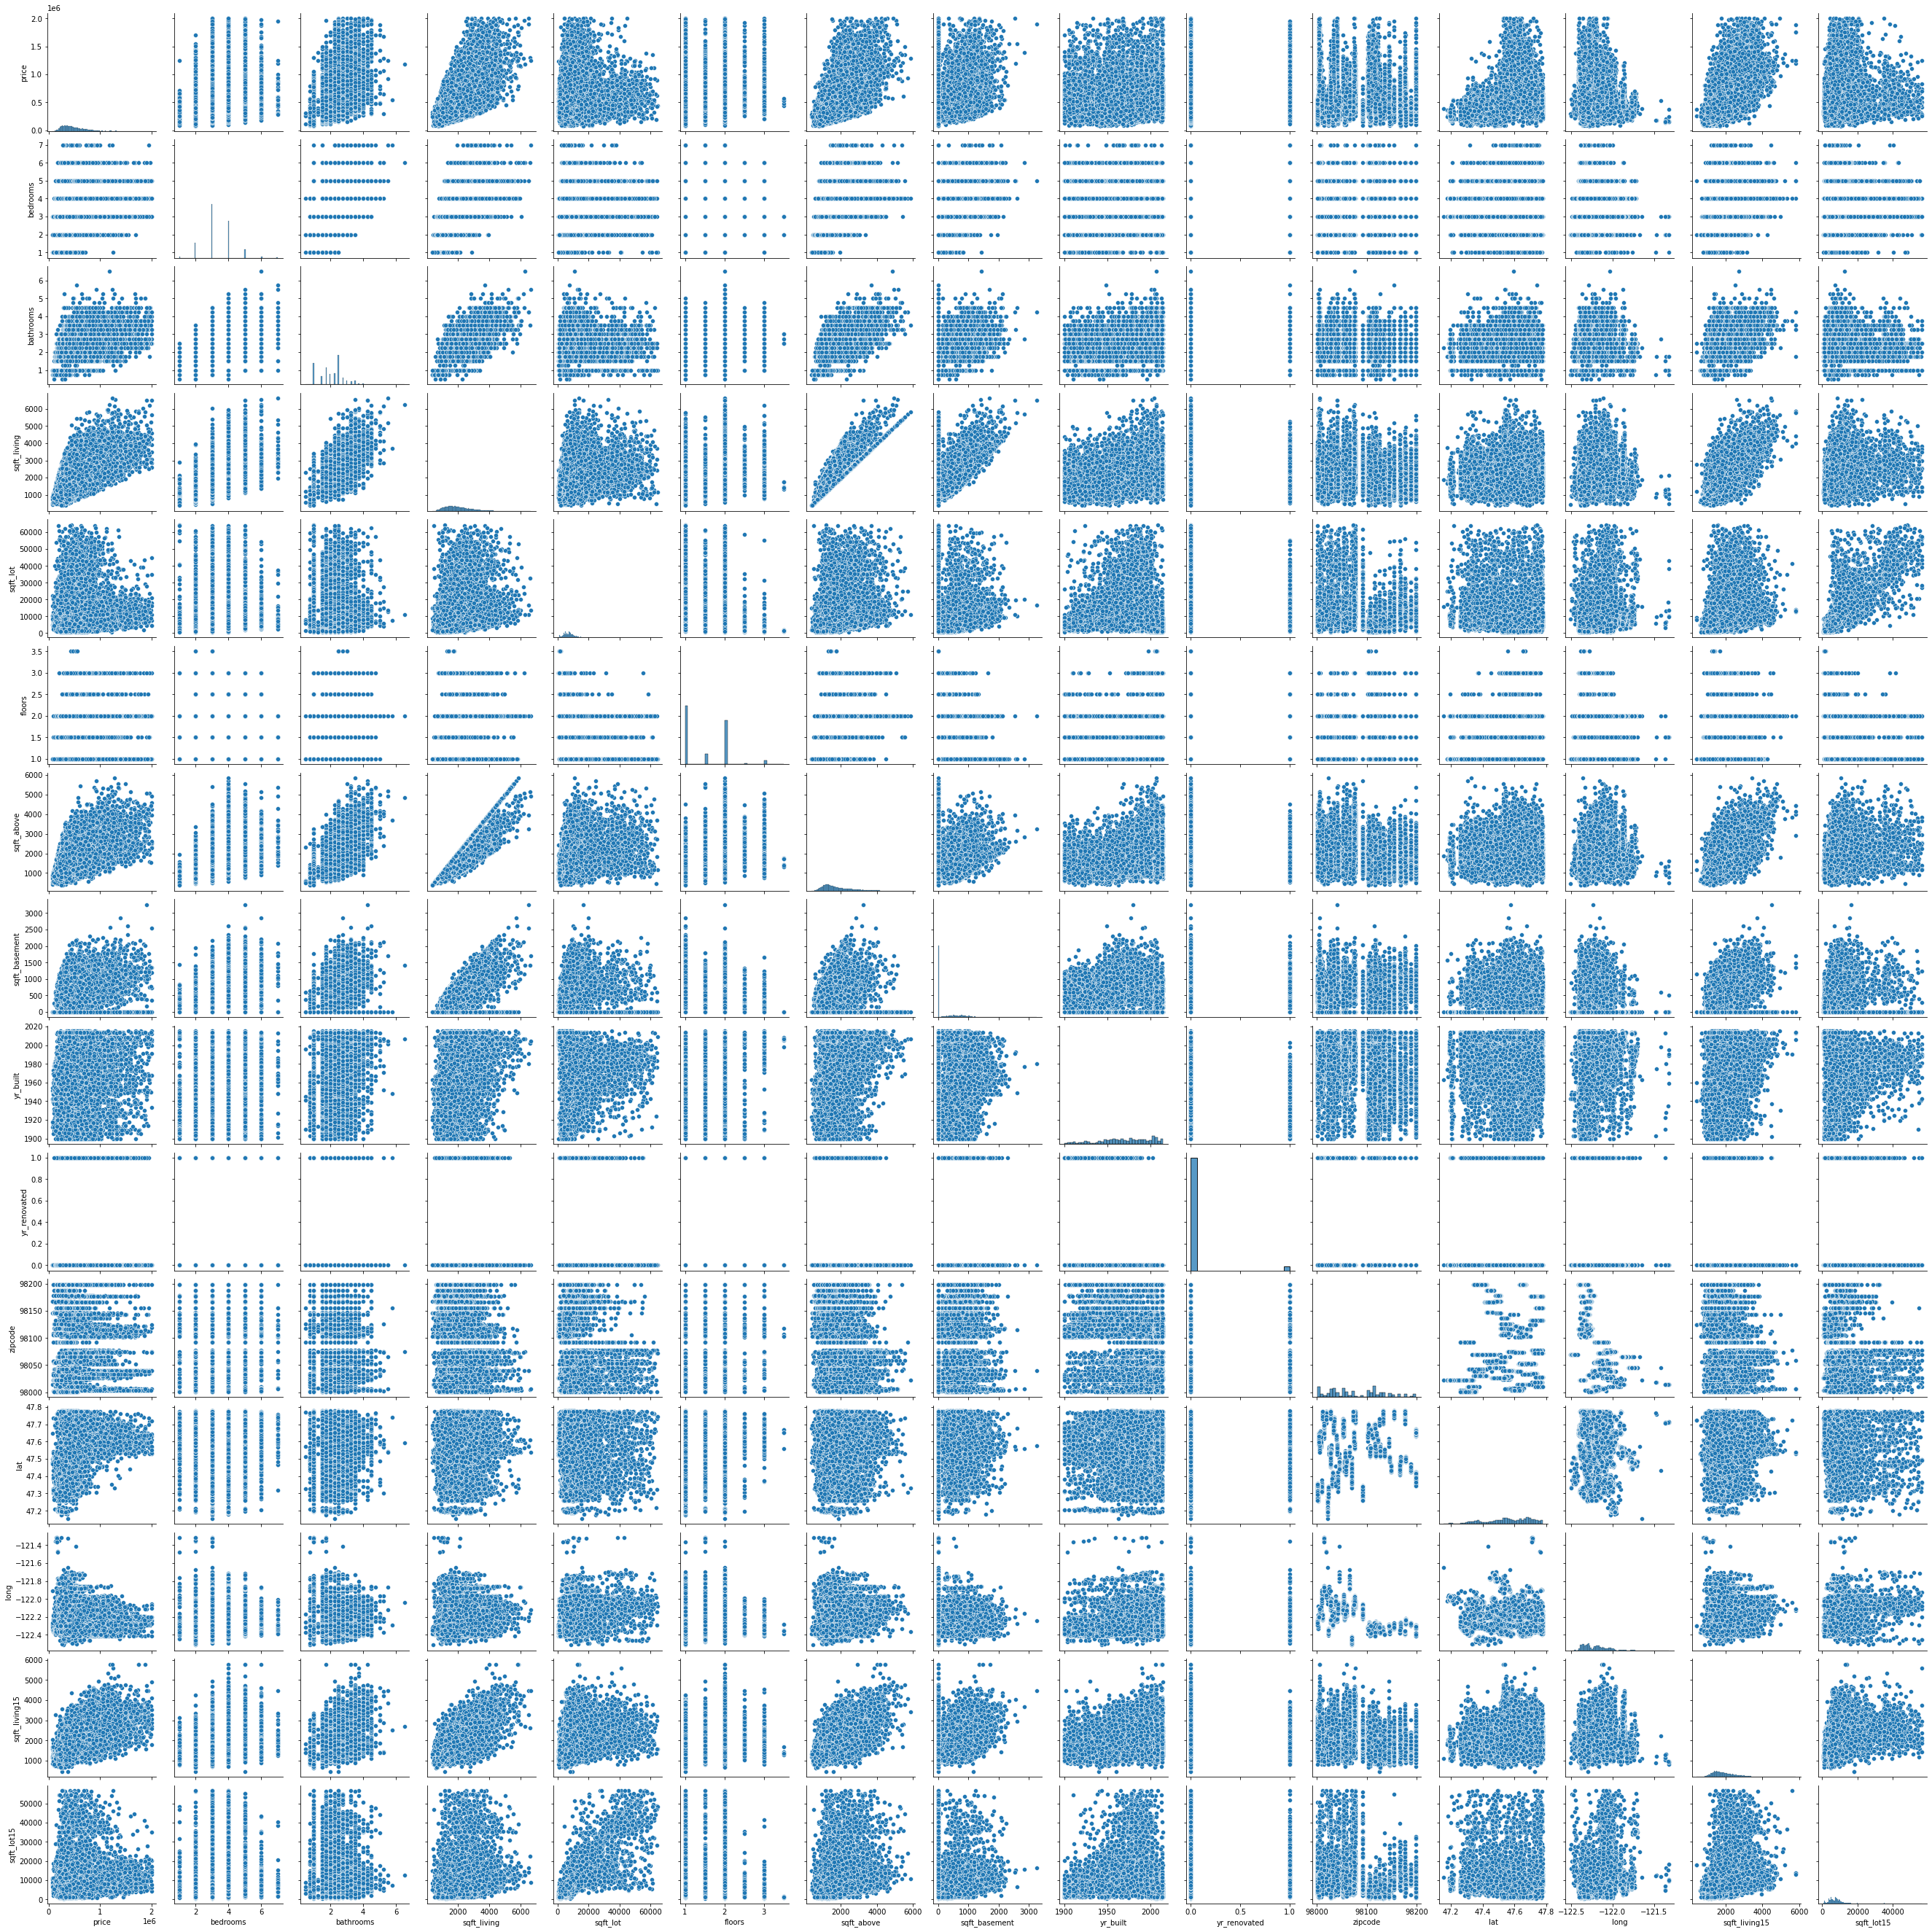

In [252]:
sns.pairplot(df)

In [253]:
x_all = df.drop('price', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, df.price, test_size = 0.33, random_state = 42)

# Round One of Modeling

In [254]:
x_train = x_train.reset_index().drop('index', axis=1)
y_train = y_train.reset_index().drop('index', axis=1)

In [255]:
cat_subset = x_train[['view', 'condition', 'grade']]
view_list = ['NONE', 'FAIR','AVERAGE', 'GOOD', 'EXCELLENT']
cond_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
grade_list = ['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent']
o_enc = OrdinalEncoder(categories = [view_list, cond_list, grade_list])
o_enc.fit(cat_subset)
x_subset = pd.DataFrame(o_enc.transform(cat_subset), columns = cat_subset.columns)
x_train[['view', 'condition', 'grade']] = x_subset

onehot = OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse = False)
temp = pd.DataFrame(onehot.fit_transform(x_train[['waterfront', 'zipcode']]), columns = onehot.get_feature_names_out())
x_train = pd.concat([x_train, temp], axis = 1)
x_train = x_train.drop(['waterfront', 'zipcode'], axis = 1)

x_train['date'] = x_train['date'].map(dt.datetime.toordinal)

In [476]:
x_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'waterfront_YES', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092',

In [478]:
lr = LinearRegression()

lr.fit(x_train,y_train)
sorted(list(zip(lr.coef_[0], x_train.columns)))

[(-62019.296250135594, 'long'),
 (-26442.643360867092, 'floors'),
 (-23406.899295930027, 'zipcode_98023'),
 (-19153.985026255446, 'zipcode_98092'),
 (-14387.605571737506, 'zipcode_98003'),
 (-11342.16773834215, 'bedrooms'),
 (-490.5738001668651, 'yr_built'),
 (-0.7526068829720316, 'sqft_lot15'),
 (1.169399648173112, 'sqft_lot'),
 (16.14262645731651, 'sqft_basement'),
 (25.661702980029077, 'sqft_living15'),
 (68.91852114068547, 'sqft_living'),
 (78.08860500969968, 'sqft_above'),
 (103.64159586697065, 'date'),
 (6218.265402366955, 'zipcode_98198'),
 (6396.941868563182, 'zipcode_98032'),
 (10829.405538055893, 'zipcode_98030'),
 (12900.518163051931, 'zipcode_98042'),
 (13896.32902389743, 'zipcode_98031'),
 (19344.211699546897, 'zipcode_98022'),
 (20630.59025853187, 'zipcode_98070'),
 (21221.62083917208, 'bathrooms'),
 (25285.851831577726, 'condition'),
 (31079.65227909792, 'zipcode_98002'),
 (31892.10447970067, 'zipcode_98188'),
 (35620.62246775448, 'zipcode_98058'),
 (40058.26886213565, '

In [256]:
y = np.log(y_train)

ss = StandardScaler()
xscaled = ss.fit_transform(x_train)
x_stand = pd.DataFrame(xscaled, columns = x_train.columns,index = x_train.index)

model = sm.OLS(y, sm.add_constant(x_stand)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     1107.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:09   Log-Likelihood:                 4385.6
No. Observations:               13762   AIC:                            -8595.
Df Residuals:                   13674   BIC:                            -7933.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.0208      0.002   8654.101      0.000      13.018      13.024
date               0.0233      0.002     15.353      0.000       0.020       0.026
bedrooms           0.0042      0.002      2.056      0.040       0.000       0.008
bathrooms          0.0315      0.003     11.593      0.000       0.026       0.037
sqft_living        0.1051      0.018      5.718      0.000       0.069       0.141
sqft_lot           0.0227      0.003      7.093      0.000       0.016       0.029
floors            -0.0173      0.002     -7.154      0.000      -0.022      -0.013
view               0.0433      0.002     24.327      0.000       0.040       0.047
condition          0.0391      0.002     22.606      0.000       0.036       0.043
grade              0.0988      0.003     34.881      0.000       0.093       0.104
sqft_above         0.0626      0.017      3.706      0.000       0.029       0.096
sqft_basement      0.0021      0.009      0.222      0.824      -0.016       0.020
yr_built          -0.0082      0.003     -3.082      0.002      -0.013      -0.003
yr_renovated       0.0146      0.002      9.072      0.000       0.011       0.018
lat                0.0485      0.013      3.810      0.000       0.024       0.073
long              -0.0531      0.010     -5.525      0.000      -0.072      -0.034
sqft_living15      0.0500      0.003     18.221      0.000       0.045       0.055
sqft_lot15        -0.0101      0.003     -3.084      0.002      -0.016      -0.004
waterfront_YES     0.0297      0.002     18.496      0.000       0.027       0.033
zipcode_98002      0.0016      0.002      0.826      0.409      -0.002       0.005
zipcode_98003      0.0016      0.002      0.808      0.419      -0.002       0.006
zipcode_98004      0.1179      0.004     30.448      0.000       0.110       0.125
zipcode_98005      0.0571      0.003     18.834      0.000       0.051       0.063
zipcode_98006      0.0899      0.004     20.117      0.000       0.081       0.099
zipcode_98007      0.0502      0.003     16.297      0.000       0.044       0.056
zipcode_98008      0.0708      0.004     17.306      0.000       0.063       0.079
zipcode_98010      0.0184      0.002      9.237      0.000       0.014       0.022
zipcode_98011      0.0318      0.004      7.287      0.000       0.023       0.040
zipcode_98014      0.0217      0.003      6.494      0.000       0.015       0.028
zipcode_98019      0.0282      0.005      6.194      0.000       0.019       0.037
zipcode_98022      0.0169      0.003      6.232      0.000       0.012       0.022
zipcode_98023     -0.0074      0.003     -2.906      0.004      -0.012      -0.002
zipcode_98024      0.0209      0.002      9.141      0.000       0.016       0.025
zipcode_98027      0.0711      0.004     17.726      0.000       0.063       0.079
zipcode_9802

In [257]:
x_test = x_test.reset_index().drop('index', axis=1)
y_test = y_test.reset_index().drop('index', axis=1)

In [258]:
cat_subset_test = x_test[['view', 'condition', 'grade']]

x_test_subset = pd.DataFrame(o_enc.transform(cat_subset_test), columns = cat_subset_test.columns)
x_test[['view', 'condition', 'grade']] = x_test_subset

save = x_test.zipcode

temp_t = pd.DataFrame(onehot.transform(x_test[['waterfront', 'zipcode']]), columns = onehot.get_feature_names_out())
x_test = pd.concat([x_test, temp_t], axis = 1)
x_test = x_test.drop(['waterfront', 'zipcode'], axis = 1)

x_test['date'] = x_test['date'].map(dt.datetime.toordinal)

In [259]:
y_t = np.log(y_test)

x_test_scaled = ss.transform(x_test)
x_test_stand = pd.DataFrame(x_test_scaled, columns = x_test.columns, index = x_test.index)

y_hat = model.predict(sm.add_constant(x_test_stand))
y_hat = np.exp(y_hat)

mae = mean_absolute_error(y_hat, y_test)
rmse = mean_squared_error(y_hat, y_test, squared = False)
rsquared = model.rsquared
print(mae, rmse, rsquared)

68268.64776717797 109552.61973935737 0.875654037260572


<AxesSubplot:xlabel='long', ylabel='lat'>

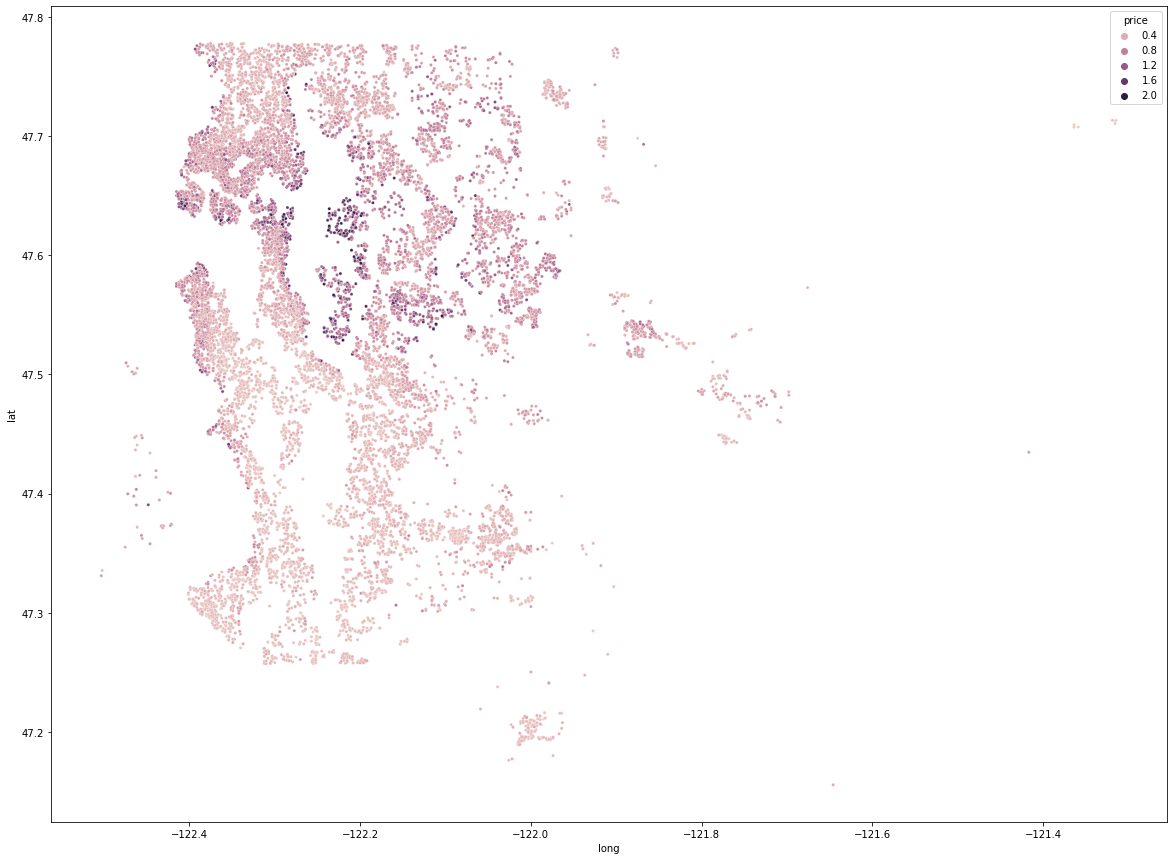

In [417]:
both = pd.concat([r3_x_train, y_train], axis=1)

fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = both, x='long', y = 'lat', hue='price', s=10, ax=ax)

# Round Two of Modeling

In [260]:
cores = x_train.corr()
maxes = []
for column in cores.columns:
    current = cores[column]
    for i in range(len(cores.columns)):
        correlation = current.tolist()[i]
        if (correlation != 1) & (np.abs(correlation) >= .7):
            maxes.append((correlation, column, current.index[i]))
maxes

[(0.7358278176736421, 'bathrooms', 'sqft_living'),
 (0.7358278176736421, 'sqft_living', 'bathrooms'),
 (0.7383293187020382, 'sqft_living', 'grade'),
 (0.8601889383381295, 'sqft_living', 'sqft_above'),
 (0.7601462826681062, 'sqft_living', 'sqft_living15'),
 (0.8768471739348445, 'sqft_lot', 'sqft_lot15'),
 (0.7383293187020382, 'grade', 'sqft_living'),
 (0.7318867886375653, 'grade', 'sqft_above'),
 (0.8601889383381295, 'sqft_above', 'sqft_living'),
 (0.7318867886375653, 'sqft_above', 'grade'),
 (0.7287307755221332, 'sqft_above', 'sqft_living15'),
 (0.7601462826681062, 'sqft_living15', 'sqft_living'),
 (0.7287307755221332, 'sqft_living15', 'sqft_above'),
 (0.8768471739348445, 'sqft_lot15', 'sqft_lot')]

In [261]:
r2_x_train = x_train
r2_x_train = r2_x_train.drop(['sqft_above', 'sqft_basement', 'sqft_lot15'], axis=1)
r2_x_train = r2_x_train.drop(['zipcode_98002','zipcode_98003','zipcode_98148','zipcode_98168',
                              'zipcode_98188', 'zipcode_98198'], axis = 1)

r2_xscaled = ss.fit_transform(r2_x_train)
r2_x_stand = pd.DataFrame(r2_xscaled, columns = r2_x_train.columns, index = r2_x_train.index)

lr2 = LinearRegression()
lr2.fit(r2_x_stand, y)
lr2.score(r2_x_stand, y)

0.8734298991333811

In [262]:
r2_x_test = x_test
r2_x_test = r2_x_test.drop(['sqft_above', 'sqft_basement', 'sqft_lot15'], axis=1)
r2_x_test = r2_x_test.drop(['zipcode_98002','zipcode_98003','zipcode_98148','zipcode_98168',
                            'zipcode_98188', 'zipcode_98198'], axis = 1)

r2_x_test_scaled = ss.transform(r2_x_test)
r2_x_test_stand = pd.DataFrame(r2_x_test_scaled, columns = r2_x_test.columns, index = r2_x_test.index)

r2_y_hat = lr2.predict(r2_x_test_stand)
r2_y_hat = np.exp(r2_y_hat)

r2_mae = mean_absolute_error(r2_y_hat, y_test)
r2_rmse = mean_squared_error(r2_y_hat, y_test, squared = False)
r2_rsquared = lr2.score(r2_x_test_stand, y_t)
print(r2_mae, r2_rmse, r2_rsquared)

68955.11917387247 110641.74440232535 0.8639246346240681


# Round Three of Modeling

In [263]:
cords = list(zip(r2_x_train.lat.tolist(), r2_x_train.long.tolist()))
food_df = pd.read_csv('./data/Food_Establishment_Inspection_Data.csv')

food_df = food_df[food_df['Inspection Closed Business'] == False]
food_df = food_df[['Name', 'Business_ID', 'Inspection Date', 'Zip Code', 'Longitude', 'Latitude', 'Inspection Score', 'Grade']]
food_df['Inspection Date'] = pd.to_datetime(food_df['Inspection Date'])
food_df = food_df[(food_df['Inspection Date'] >= '01-01-2012') & (food_df['Inspection Date'] <= '01-01-2017')]
food_df = food_df.sort_values(['Name', 'Inspection Date'], ascending= [True, False])
food_df = food_df.drop_duplicates(subset=['Longitude', 'Latitude'], keep = 'first')
food_df['Grade'] = food_df.Grade.fillna(0).replace('N',0, regex=True).astype('int64')
food_df.dropna(inplace=True)
rests = list(zip(food_df['Latitude'].round(4).tolist(), food_df['Longitude'].round(4).tolist()))

medical_df = pd.read_csv('./data/Medical_Facilities_including_Hospitals___medical_facilities_point.csv')
meds = list(zip(medical_df['Y'].round(4).tolist(), medical_df['X'].round(4).tolist()))

parks_df = pd.read_csv('./data/Park_Label_Points___park_label_point.csv')
parks = list(zip(parks_df['Y'].round(4).tolist(), parks_df['X'].round(4).tolist()))

mile2 = 0.0429
d_to_city = []
rest_in_range = []
closest_medical = []
parks_in_range = []

for cord in cords:
    d_seattle = np.abs(cord[0] - 47.6062) + np.abs(cord[1] - -122.3321)
    d_bellevue = np.abs(cord[0] - 47.6101) + np.abs(cord[1] - -122.2015)
    ds = [d_seattle, d_bellevue]
    d_to_city.append(max(ds))
    
    in_range = []
    for rest in rests:
        if (np.abs(cord[0] - rest[0]) + np.abs(cord[1] - rest[1])) <= mile2:
            in_range.append(rest)
    rest_in_range.append(len(in_range))
    
    distances = []
    for med in meds:
        distances.append(round(np.abs(cord[0] - med[0]) + np.abs(cord[1] - med[1]), 4))
    closest_medical.append(min(distances))
    
    p_in_range = []
    for park in parks:
        if (np.abs(cord[0] - park[0]) + np.abs(cord[1] - park[1])) <= mile2:
            p_in_range.append(park)
    parks_in_range.append(len(p_in_range))

C:\Users\jackl\AppData\Local\Temp\ipykernel_17804\3431440403.py:2: DtypeWarning: Columns (6,21) have mixed types. Specify dtype option on import or set low_memory=False.
  food_df = pd.read_csv('./data/Food_Establishment_Inspection_Data.csv')


In [333]:
r3_x_train = r2_x_train
r3_x_train['food'] = rest_in_range
r3_x_train['medical'] = closest_medical
r3_x_train['parks'] = parks_in_range
r3_x_train['city_distance'] = d_to_city

In [334]:
r3_xscaled = ss.fit_transform(r3_x_train)
r3_x_stand = pd.DataFrame(r3_xscaled, columns = r3_x_train.columns, index = r3_x_train.index)

lr3 = LinearRegression()
lr3.fit(r3_x_stand, y)
r3_score = lr3.score(r3_x_stand, y)
print(r3_score)

0.8747694335660277


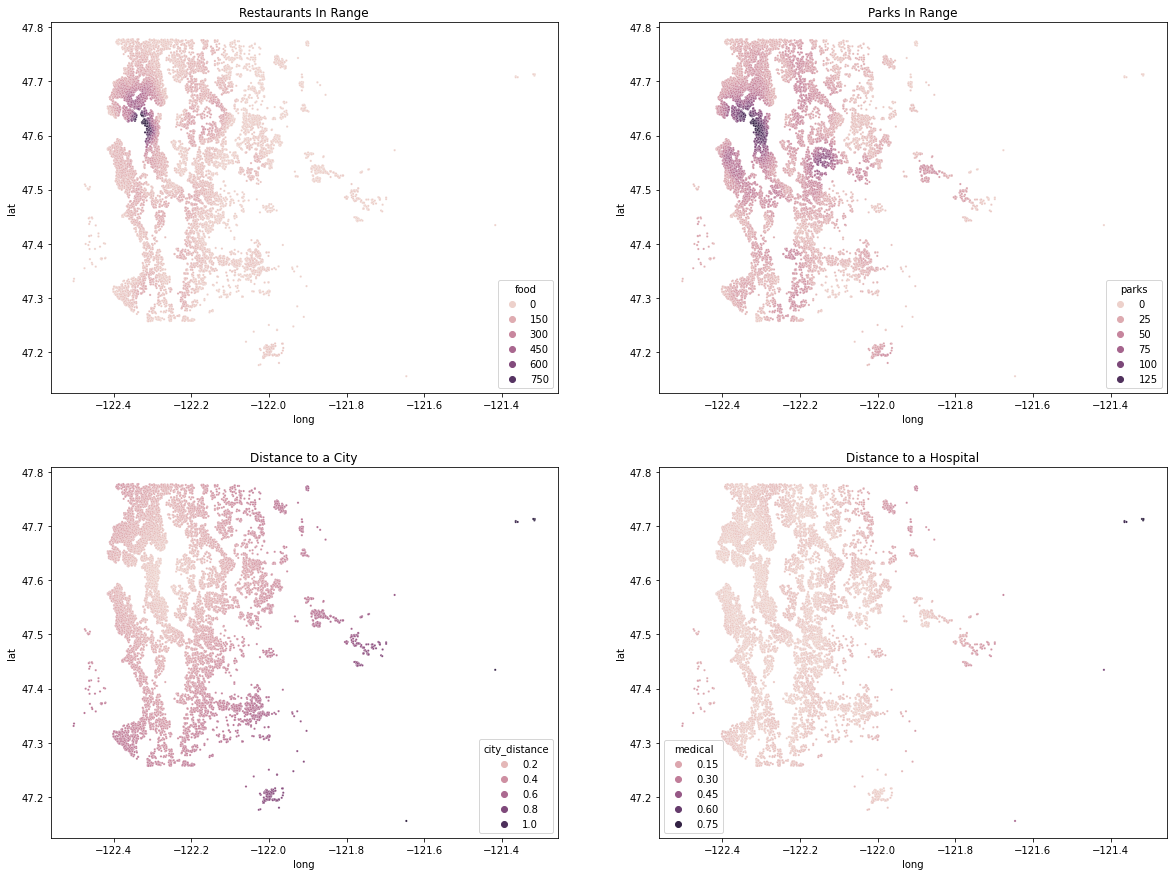

In [412]:
fig, axs = plt.subplots(2,2, figsize = (20,15))
sns.scatterplot(data = r3_x_train, x='long', y = 'lat', hue = 'food', s=5, ax = axs[0,0])
axs[0,0].set_title('Restaurants In Range')
sns.scatterplot(data = r3_x_train, x='long', y = 'lat', hue = 'parks', s=5, ax = axs[0,1])
axs[0,1].set_title('Parks In Range')
sns.scatterplot(data = r3_x_train, x='long', y = 'lat', hue = 'city_distance', s=5,ax = axs[1,0])
axs[1,0].set_title('Distance to a City')
sns.scatterplot(data = r3_x_train, x='long', y = 'lat', hue = 'medical', s=5, ax = axs[1,1])
axs[1,1].set_title('Distance to a Hospital')
plt.show()

In [266]:
test_cords = list(zip(r2_x_test.lat.tolist(), r2_x_test.long.tolist()))
d_to_city_test = []
rest_in_range_test = []
closest_medical_test = []
parks_in_range_test = []

for cord in test_cords:
    d_seattle = np.abs(cord[0] - 47.6062) + np.abs(cord[1] - -122.3321)
    d_bellevue = np.abs(cord[0] - 47.6101) + np.abs(cord[1] - -122.2015)
    ds = [d_seattle, d_bellevue]
    d_to_city_test.append(max(ds))
    
    in_range = []
    for rest in rests:
        if (np.abs(cord[0] - rest[0]) + np.abs(cord[1] - rest[1])) <= mile2:
            in_range.append(rest)
    rest_in_range_test.append(len(in_range))
    
    distances = []
    for med in meds:
        distances.append(round(np.abs(cord[0] - med[0]) + np.abs(cord[1] - med[1]), 4))
    closest_medical_test.append(min(distances))
    
    p_in_range = []
    for park in parks:
        if (np.abs(cord[0] - park[0]) + np.abs(cord[1] - park[1])) <= mile2:
            p_in_range.append(park)
    parks_in_range_test.append(len(p_in_range))

In [345]:
r3_x_test = r2_x_test
r3_x_test['food'] = rest_in_range_test
r3_x_test['medical'] = closest_medical_test
r3_x_test['parks'] = parks_in_range_test
r3_x_test['city_distance'] = d_to_city_test

In [348]:
r3_x_test_scaled = ss.transform(r3_x_test)
r3_x_test_stand = pd.DataFrame(r3_x_test_scaled, columns = r3_x_test.columns, index = r3_x_test.index)

r3_y_hat = lr3.predict(r3_x_test_stand)
r3_y_hat = np.exp(r3_y_hat)
r3_y_hat = [item for sub in r3_y_hat for item in sub]

r3_mae = mean_absolute_error(r3_y_hat, y_test)
r3_rmse = mean_squared_error(r3_y_hat, y_test, squared = False)
r3_rsquared = lr3.score(r3_x_test_stand, y_t)
print(r3_mae, r3_rmse, r3_rsquared)

68013.95372461465 109276.15904459586 0.8659359486846289


# Round Four of Modeling

In [403]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
poly_df = pd.DataFrame(poly.fit_transform(r3_x_train), columns = poly.get_feature_names_out())

poly_scaled = ss.fit_transform(poly_df)
poly_stand = pd.DataFrame(poly_scaled, columns = poly_df.columns, index = poly_df.index)

poly_mod = sm.OLS(y, sm.add_constant(poly_stand)).fit()
poly_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     107.0
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:09:13   Log-Likelihood:                 7478.0
No. Observations:               13762   AIC:                        -1.226e+04
Df Residuals:                   12414   BIC:                            -2110.
Df Model:                        1347                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           13.0208      0.001   1.03e+04      0.000      13.018      13.023
date                             4.1359      9.785      0.423      0.673     -15.045      23.317
bedrooms                        11.0908     17.943      0.618      0.537     -24.080      46.262
bathrooms                        6.3647     24.091      0.264      0.792     -40.857      53.586
sqft_living                     20.6816     30.000      0.689      0.491     -38.123      79.486
sqft_lot                       -39.1686     19.514     -2.007      0.045     -77.418      -0.919
floors                         -51.6694     18.766     -2.753      0.006     -88.453     -14.886
view                           -28.0021     17.698     -1.582      0.114     -62.693       6.689
condition                       57.5859     15.453      3.727      0.000      27.296      87.876
grade                           36.3107     24.851      1.461      0.144     -12.402      85.023
yr_built                        50.8191     25.162      2.020      0.043       1.499     100.140
yr_renovated                    24.8025     16.102      1.540      0.123      -6.759      56.364
lat                           -237.7590    105.780     -2.248      0.025    -445.104     -30.414
long                           105.6727     74.058      1.427      0.154     -39.493     250.839
sqft_living15                    6.8185     25.606      0.266      0.790     -43.373      57.010
waterfront_YES                 333.6861     93.279      3.577      0.000     150.845     516.527
zipcode_98004                 -218.1596     81.607     -2.673      0.008    -378.122     -58.197
zipcode_98005                   -8.1881     41.012     -0.200      0.842     -88.579      72.203
zipcode_98006                   -9.4769      7.945     -1.193      0.233     -25.051       6.097
zipcode_98007                   70.6705     68.028      1.039      0.299     -62.674     204.015
zipcode_98008                 -160.0515    160.397     -0.998      0.318    -474.454     154.351
zipcode_98010                   -0.3699      5.409     -0.068      0.945     -10.972      10.232
zipcode_98011                   30.7484     21.948      1.401      0.161     -12.272      73.769
zipcode_98014                   20.5074     17.904      1.145      0.252     -14.587      55.602
zipcode_98019                   33.7549     27.834      1.213      0.225     -20.804      88.314
zipcode_98022                   -5.9217      6.805     -0.870      0.384     -19.261       7.418
zipcode_98023                   40.9963     20.466      2.003      0.045       0.881      81.112
zipcode_98024                  -10.4172      5.143     -2.026      0.043     -20.498      -0.336
zipcode_98027                  -17.2695      7.831     -2.205      0.027    

In [404]:
polylr = LinearRegression()
polylr.fit(poly_stand, y)
polylr.score(poly_stand, y)

0.92066628422116

In [405]:
poly_dict = dict(zip(poly_df.columns, polylr.coef_[0]))
temp_df = pd.DataFrame()
temp_df['name'] = poly_dict.keys()
temp_df['coefs'] = poly_dict.values()
steve = temp_df.sort_values(['coefs'], ascending=False)
#steve[steve['name'].str.contains('water')].head(50)
steve

name         coefs
2541  zipcode_98045 city_distance  9.683705e+09
1023           long zipcode_98072  3.376460e+09
1014           long zipcode_98045  3.076404e+09
48                  zipcode_98072  2.065831e+09
1026           long zipcode_98077  1.653308e+09
...                           ...           ...
52                  zipcode_98092 -1.948694e+09
63                  zipcode_98117 -2.163102e+09
2539        zipcode_98045 medical -2.357055e+09
54                  zipcode_98103 -2.419733e+09
39                  zipcode_98045 -3.123954e+09

[3403 rows x 2 columns]

In [415]:
poly_test_df = pd.DataFrame(poly.transform(r3_x_test), columns = poly.get_feature_names_out())

poly_test_scaled = ss.transform(poly_test_df)
poly_test_stand = pd.DataFrame(poly_test_scaled, columns = poly_test_df.columns, index = poly_test_df.index)

poly_y_hat = polylr.predict(poly_test_stand)
poly_y_hat = np.exp(poly_y_hat)

polylr.score(poly_test_stand, y_t)


C:\Users\jackl\AppData\Local\Temp\ipykernel_17804\2632188080.py:7: RuntimeWarning: overflow encountered in exp
  poly_y_hat = np.exp(poly_y_hat)


-1.8464346964634856e+16

# Interperating the Results

In [418]:
flip = pd.DataFrame()
flip['difference'] = r3_y_hat - y_test.price
flip['zip'] = save
flip.groupby('zip').sum()['difference'].sort_values().head()

zip
98118   -6.139931e+06
98199   -3.845493e+06
98056   -3.335660e+06
98115   -2.984994e+06
98146   -2.837919e+06
Name: difference, dtype: float64

# Finding out what to do specifically 

In [433]:
coefs = dict(zip(r3_x_train.columns, lr3.coef_[0]))
coef_df = pd.DataFrame()
coef_df['coef'] = coefs.values()
coef_df['variable'] = coefs.keys()
coef_df.sort_values('coef', inplace = True, ascending = False)
coef_df[~coef_df['variable'].str.contains('zip')]

coef        variable
3   0.148276     sqft_living
8   0.106196           grade
13  0.052951   sqft_living15
6   0.039203            view
7   0.036732       condition
14  0.030094  waterfront_YES
2   0.026016       bathrooms
0   0.023520            date
4   0.016206        sqft_lot
10  0.014042    yr_renovated
80  0.012197           parks
79  0.006965         medical
1   0.003823        bedrooms
12  0.000669            long
5   0.000189          floors
11 -0.007646             lat
9  -0.010973        yr_built
78 -0.011467            food
81 -0.092350   city_distance

In [479]:
tl = LinearRegression()
tl.fit(r3_x_train, y_train)
tl.score(r3_x_train, y_train)
coefs2 = dict(zip(r3_x_train.columns, tl.coef_[0]))
coef_df2 = pd.DataFrame()
coef_df2['coef'] = coefs2.values()
coef_df2['variable'] = coefs2.keys()
coef_df2.sort_values('coef', inplace = True, ascending = False)
coef_df2 = coef_df2[~coef_df2['variable'].str.contains('zip')]
coef_df2

coef        variable
14  393729.189647  waterfront_YES
12  281097.208180            long
79  181129.573209         medical
8    57741.607888           grade
6    46581.304080            view
10   37082.652213    yr_renovated
7    21928.496878       condition
2    15052.801353       bathrooms
5     1239.799752          floors
80     495.561377           parks
3      122.830572     sqft_living
0      104.833180            date
13      27.764751   sqft_living15
4        0.778229        sqft_lot
78    -185.594911            food
9     -588.731044        yr_built
1   -11539.016361        bedrooms
11 -149375.776869             lat
81 -607728.214647   city_distance

In [480]:
0.429 /2

0.2145

In [481]:
1 / 0.2145

4.662004662004662